# SEN12 KMeans Clustering
---
Last Modified: April 12, 2020

1. Cluster pixels according to SEN12 bands
2. Cluster images according to pixels' color cluster indices
3. Cluster images according to stacked SEN12 band histograms
4. Compare image-cluster distributions between continents

In [1]:
### Important: Run this cell before any other cells! ###

### Imports ###

import sys
sys.path.append('../')

# general imports
import csv
import os
import time
import json
import numpy as np
import scipy.stats as sp_stats
import pandas as pd
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt

# KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans

# land-cover imports
import land_cover_utils
import datagen

DATA_DIR = '/data/datasets/sen12ms_segmentation'

# load config
print('loading config...')
with open('/home/lucas/land-cover/config.json', 'r') as f:
    config = json.load(f, object_hook=land_cover_utils.json_keys_to_int)

# SEN12 settings
img_size = config['training_params']['patch_size']
num_bands = len(config['s1_input_bands']) + len(config['s2_input_bands'])
sen12_bands = config['s1_input_bands'] + config['s2_input_bands']
print(f'SEN12 input bands: {sen12_bands}')

# SEN12 summary statistics
s1_mean = np.array(config['s1_band_means'])
s1_std = np.array(config['s1_band_std'])
s2_mean = np.array(config['s2_band_means'])
s2_std = np.array(config['s2_band_std'])
# stacked
sen12_means = np.hstack((s1_mean, s2_mean))
sen12_std = np.hstack((s1_std, s2_std))

### Helper Functions ###

def get_all_patch_paths():
    ''' return all patch_paths '''
    patch_paths = []
    continents = config['all_continents']
    for continent in continents:
        continent_scene_dirs = land_cover_utils.get_scene_dirs_for_continent(continent, config)
        continent_patch_paths = land_cover_utils.get_segmentation_patch_paths_for_scene_dirs(continent_scene_dirs)
        patch_paths += continent_patch_paths
    return patch_paths

def get_all_continent_seasons():
    ''' return all (continent, season) tuples '''
    continents = config['all_continents']
    seasons = config['all_seasons']
    continent_seasons = []
    for continent in continents:
        for season in seasons:
            continent_seasons.append((continent, season))
    return continent_seasons

def normalize_bands(image):
    ''' normalize image/batch using SEN12 means/std '''
    normalized = (image - sen12_means) / sen12_std
    return normalized

def batch_to_color_ind_hists(batch, kmeans_color):
    ''' get color-cluster-index histograms for each image in batch '''
    num_samples = len(batch)
    num_color_clusters = len(kmeans_color.cluster_centers_)
    batch = batch.reshape((-1, num_bands))
    cluster_inds = kmeans_color.predict(batch).reshape((num_samples, img_size * img_size)) # throws an error if has NaN
    color_ind_hists = []
    # get color-cluster histogram for each image
    for image_cluster_inds in cluster_inds:
        hist = np.bincount(image_cluster_inds, minlength=num_color_clusters)
        hist = hist / hist.sum()
        color_ind_hists.append(hist)
    color_ind_hists = np.vstack(color_ind_hists)
    return color_ind_hists

def image_to_color_cluster_hist(image, kmeans_color):
    ''' get color-cluster-index histogram for a single image '''
    num_color_clusters = len(kmeans_color.cluster_centers_)
    image = image.reshape((-1, num_bands)) # flatten for KMeans prediction
    cluster_inds = kmeans_color.predict(image).reshape(img_size * img_size) # throws an error if has NaN
    hist = np.bincount(cluster_inds, minlength=num_color_clusters)
    hist = hist / hist.sum()
    return hist

def get_sen12_bins(standardize=False):
    ''' get SEN12 histogram bins in a numpy array '''
    sen12_bins = np.array(config['s1_band_quartiles'] + config['s2_band_quartiles']) # (25%, 50%, 75%)
    sen12_bins = np.hstack([np.full((num_bands, 1), -50), sen12_bins]) # left boundary
    sen12_bins = np.hstack([sen12_bins, np.full((num_bands, 1), 30000)]) # right boundary
    if standardize:
        sen12_means = np.hstack((s1_mean, s2_mean)).reshape((12, 1)).repeat(sen12_bins.shape[1], axis=1)
        sen12_std = np.hstack((s1_std, s2_std)).reshape((12, 1)).repeat(sen12_bins.shape[1], axis=1)
        sen12_bins = (sen12_bins - sen12_means) / sen12_std
    return sen12_bins

def image_to_stacked_band_histogram(image, sen12_bins):
    ''' get stacked band histogram representation of a 256x256xnum_bands image '''
    image = image.reshape((img_size * img_size, num_bands))
    hists = [np.histogram(image[:, i],
                          bins=sen12_bins[i],
                          density=True)[0] \
             for i in range(len(sen12_bands))]
    hists = np.hstack(hists)
    return hists

def batch_to_stacked_band_histograms(batch, sen12_bins):
    ''' get stacked band histogram representations of a batch of images '''
    return np.array([image_to_stacked_band_histogram(image, sen12_bins) for image in batch])

def image_to_band_means(image):
    ''' get band-means representations of a batch of a single image '''
    return np.nanmean(image, axis=(0,1))

def batch_to_band_means(batch):
    ''' get band-means representations of a batch of images '''
    return np.nanmean(batch, axis=(1,2))

def nearest_neighbor_ind(X, centroid):
    ''' get index of X that is closest to the centroid '''
    dist = np.linalg.norm(X - centroid, axis=1)
    return np.argmin(dist)

cluster_method_to_cluster_col = {
    'colorcluster': 'image_cluster_color',
    'bandhist': 'image_cluster_bandhist',
    'bandmeans': 'image_cluster_bandmeans'
}

cluster_method_to_method_name = {
    'colorcluster': 'Color-Cluster',
    'bandhist': 'Band-Histogram',
    'bandmeans': 'Band-Means'
}

cluster_method_to_feat_col = {
    'colorcluster': 'color_cluster_hist',
    'bandhist': 'sen12_band_hist',
    'bandmeans': 'sen12_band_means'
}
    

Using TensorFlow backend.


loading config...
SEN12 input bands: ['VV', 'VH', 'blue', 'green', 'red', 're1', 're2', 're3', 'nir1', 'nir2', 'swir1', 'swir2']


## Step 1: Fit Color-KMeans on SEN12 Bands

In [4]:
### Cluster pixels according to SEN12 bands ###

# kmeans settings
num_clusters_list = [32, 16, 64, 24, 48]
images_per_batch = 64
np.random.seed(20200404)

# update config
config['fc_densenet_params']['batch_size'] = images_per_batch # set batch size for datagen

# Get all patch_paths
patch_paths = get_all_patch_paths()
print(f'Total number of patches: {len(patch_paths)}')

# Get datagen in random order
np.random.shuffle(patch_paths)
kmeans_datagen = datagen.SegmentationDataGenerator(patch_paths, config, labels=None)
pixels_per_batch = images_per_batch * img_size * img_size
print(f'Images per batch: {images_per_batch}')
print(f'Number of batches: {len(kmeans_datagen)}')
print(f'Pixels per batch: {pixels_per_batch}')
print()

def fit_color_kmeans(num_clusters=32):
    ''' fit and save kmeans model '''
    # init KMeans model
    kmeans = MiniBatchKMeans(num_clusters, batch_size=pixels_per_batch)

    # fit on mini-batches. Note: each mini-batch is standardized by the datagen
    start = time.time()
    print(f'--- Fitting KMeans model with {num_clusters} clusters ---')
    for i, batch in enumerate(kmeans_datagen):
        if i % 50 == 0 and i != 0:
            seconds_per_batch = (time.time() - start) / i
            print(f'batch {i} out of {len(kmeans_datagen)} (seconds per batch: {seconds_per_batch:.2f})...')
        batch = batch.reshape((images_per_batch * img_size * img_size, num_bands)) # reshape
        np.random.shuffle(batch) # shuffle
        try:
            kmeans.partial_fit(batch) # fit on batch
        except:
            print('Warning: partial_fit() on batch failed!')
        
    # reset datagen
    kmeans_datagen.on_epoch_end()

    # dump trained model
    save_dir = f'../kmeans/kmeans_{num_clusters}.joblib'
    joblib.dump(kmeans, save_dir)
    print(f'Saved final KMeans model to {save_dir}!')
    print()

# fit kmeans models for multiple numbers of clusters
for num_clusters in num_clusters_list:
    break # TODO: comment this to train model
    fit_color_kmeans(num_clusters=num_clusters)


Total number of patches: 180662
Images per batch: 64
Number of batches: 2823
Pixels per batch: 4194304

--- Fitting KMeans model with 32 clusters ---
batch 50 out of 2823 (seconds per batch: 8.76)...
batch 100 out of 2823 (seconds per batch: 9.05)...
batch 150 out of 2823 (seconds per batch: 9.35)...
batch 200 out of 2823 (seconds per batch: 9.49)...
batch 250 out of 2823 (seconds per batch: 9.59)...
batch 300 out of 2823 (seconds per batch: 9.65)...
batch 350 out of 2823 (seconds per batch: 9.70)...
batch 400 out of 2823 (seconds per batch: 9.73)...
batch 450 out of 2823 (seconds per batch: 9.75)...
batch 500 out of 2823 (seconds per batch: 9.78)...
batch 550 out of 2823 (seconds per batch: 9.79)...
batch 600 out of 2823 (seconds per batch: 9.81)...
batch 650 out of 2823 (seconds per batch: 9.82)...
batch 700 out of 2823 (seconds per batch: 9.83)...
batch 750 out of 2823 (seconds per batch: 9.84)...
batch 800 out of 2823 (seconds per batch: 9.85)...
batch 850 out of 2823 (seconds per 

batch 1900 out of 2823 (seconds per batch: 12.47)...
batch 1950 out of 2823 (seconds per batch: 12.47)...
batch 2000 out of 2823 (seconds per batch: 12.47)...
batch 2050 out of 2823 (seconds per batch: 12.47)...
batch 2100 out of 2823 (seconds per batch: 12.47)...
batch 2150 out of 2823 (seconds per batch: 12.47)...
batch 2200 out of 2823 (seconds per batch: 12.47)...
batch 2250 out of 2823 (seconds per batch: 12.47)...
batch 2300 out of 2823 (seconds per batch: 12.47)...
batch 2350 out of 2823 (seconds per batch: 12.47)...
batch 2400 out of 2823 (seconds per batch: 12.47)...
batch 2450 out of 2823 (seconds per batch: 12.47)...
batch 2500 out of 2823 (seconds per batch: 12.47)...
batch 2550 out of 2823 (seconds per batch: 12.47)...
batch 2600 out of 2823 (seconds per batch: 12.48)...
batch 2650 out of 2823 (seconds per batch: 12.48)...
batch 2700 out of 2823 (seconds per batch: 12.48)...
batch 2750 out of 2823 (seconds per batch: 12.48)...
batch 2800 out of 2823 (seconds per batch: 12.

Total number of patches: 180662
Generating subsample of dataset...
batch 0 out of 6...
X.shape: (50328, 12)

Calculating silhouette score for K = 32...
Score: 0.16772334124811325
Calculating silhouette score for K = 16...
Score: 0.2101600295834199
Calculating silhouette score for K = 24...
Score: 0.17585288657801487
Calculating silhouette score for K = 48...
Score: 0.15735516157811183
Calculating silhouette score for K = 64...
Score: 0.1478932266099763


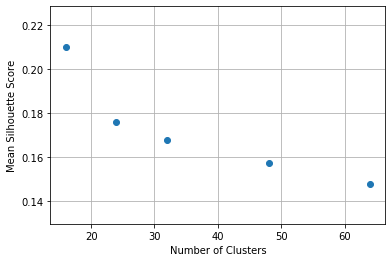

In [24]:
### Evaluate KMeans using Silhouette Score ###

# Settings
np.random.seed(20200407)
images_per_batch = 64
patch_subsampling_factor = 500 # can't fit whole dataset into RAM for silhouette score calculation
pixel_subsampling_factor = 500

# update config
config['fc_densenet_params']['batch_size'] = images_per_batch # set batch size for datagen

# Get all patch_paths
patch_paths = get_all_patch_paths()
print(f'Total number of patches: {len(patch_paths)}')

# Subsample pixels on which to evaluate
print('Generating subsample of dataset...')
X = []
patch_paths = np.random.choice(patch_paths, len(patch_paths) // patch_subsampling_factor, replace=False)
np.random.shuffle(patch_paths)
kmeans_datagen = datagen.SegmentationDataGenerator(patch_paths, config, labels=None)
for i, batch in enumerate(kmeans_datagen):
    if i % 50 == 0:
        print(f'batch {i} out of {len(kmeans_datagen)}...')
    batch = batch.reshape((-1, num_bands)) # reshape
    sample_inds = np.random.choice(len(batch), len(batch) // pixel_subsampling_factor, replace=False)
    sampled = batch[sample_inds]
    X.append(sampled)
X = np.concatenate(X, axis=0)
print(f'X.shape: {X.shape}')
print()

# Evaluate each saved Color KMeans model
num_clusters_list = []
silhouette_score_list = []
for kmeans_file in os.listdir('../kmeans/'):
    # load KMeans model
    if 'image' in kmeans_file or not kmeans_file.endswith('.joblib'):
        continue
    kmeans = joblib.load(f'../kmeans/{kmeans_file}')
    num_clusters = int(kmeans_file.split('kmeans_')[-1].split('.joblib')[0])
    # calculate silhouette score
    print(f'Calculating silhouette score for K = {num_clusters}...')
    cluster_labels = kmeans.predict(X)
    score = silhouette_score(X, cluster_labels)
    print(f'Score: {score}')
    # store results
    num_clusters_list.append(num_clusters)
    silhouette_score_list.append(score)

# make scatter plot
plt.scatter(num_clusters_list, silhouette_score_list)
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Silhouette Score')
plt.grid()
plt.show()


Sampled patch: /data/datasets/sen12ms_segmentation/North_America-fall/scene_1/patch_555
patch.shape: (256, 256, 12)
cluster_inds.shape: (256, 256)


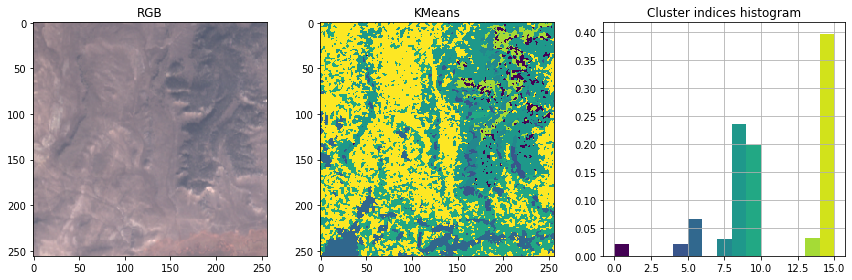

In [132]:
### Visualize color clusters ###

# settings
# np.random.seed(20200407)
num_clusters = 16
kmeans_file = f'../kmeans/kmeans_{num_clusters}.joblib'
kmeans = joblib.load(kmeans_file)
continent = 'North_America'

# get all patch_paths for this continent
scene_dirs = land_cover_utils.get_scene_dirs_for_continent(continent, config)
patch_paths = land_cover_utils.get_segmentation_patch_paths_for_scene_dirs(scene_dirs)

# sample 1 patch
patch_path = np.random.choice(patch_paths)
print(f'Sampled patch: {patch_path}')

# load patch data
kmeans_datagen = datagen.SegmentationDataGenerator([patch_path], config, labels=None)
patch = next(iter(kmeans_datagen))[0]
print(f'patch.shape: {patch.shape}')

# call kmeans predict
cluster_inds = kmeans.predict(patch.reshape(-1, num_bands)).reshape((img_size, img_size))
print(f'cluster_inds.shape: {cluster_inds.shape}')

# get RGB of patch
s2 = np.load(f'{patch_path}/s2.npy')
rgb = s2[:, :, [2, 1, 0]]
rgb = rgb / rgb.max()

# set colormap
cmap = plt.cm.viridis  # define the colormap
cmaplist = [cmap(i) for i in np.linspace(0, 1, num_clusters)]
cmap = mpl.colors.ListedColormap(cmaplist)

# generate plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(rgb)
axes[0].set_title('RGB')
axes[1].imshow(cluster_inds, cmap=cmap)
axes[1].set_title('KMeans')
N, bins, patches = axes[2].hist(cluster_inds.flatten(), bins=range(0,16), density=True)
# set bar colors: https://stackoverflow.com/a/49290555
for i in range(len(patches)):
    patches[i].set_facecolor(cmaplist[i])
axes[2].grid()
axes[2].set_title('Cluster indices histogram')
fig.tight_layout()
plt.show()

## Step 2: Fit Image-KMeans Model on Color Clusters

In [2]:
### Cluster images according to color-cluster histogram ###

# Settings
num_color_clusters = 16
num_image_clusters = 16

np.random.seed(20200407)

images_per_batch = 256

# update config
config['fc_densenet_params']['batch_size'] = images_per_batch # set batch size for datagen

# Get all patch_paths
patch_paths = get_all_patch_paths()
print(f'Total number of patches: {len(patch_paths)}')

# Get datagen in random order
np.random.shuffle(patch_paths)
kmeans_datagen = datagen.SegmentationDataGenerator(patch_paths, config, labels=None)
pixels_per_batch = images_per_batch * img_size * img_size
print(f'Images per batch: {images_per_batch}')
print(f'Number of batches: {len(kmeans_datagen)}')
print(f'Pixels per batch: {pixels_per_batch}')
print()

# load color-kmeans model
kmeans_color = joblib.load(f'../kmeans/kmeans_{num_color_clusters}.joblib')
# init image-kmeans model
kmeans_image = MiniBatchKMeans(num_image_clusters, batch_size=images_per_batch)

# fit image-kmeans model on color-cluster-histograms
start = time.time()
print(f'--- Fitting Image-KMeans (Color-Cluster) model with {num_image_clusters} clusters ---')
for i, batch in enumerate(kmeans_datagen):
    break # TODO: comment this to train model
    if i % 20 == 0 and i != 0:
        seconds_per_batch = (time.time() - start) / i
        print(f'batch {i} out of {len(kmeans_datagen)} (seconds per batch: {seconds_per_batch:.2f})...')
    # get color-cluster-inds for each image in batch
    try:
        color_ind_hists = batch_to_color_ind_hists(batch, kmeans_color)
    except:
        print('Warning: batch_to_color_ind_hists() failed!')
        continue
    # fit image-kmeans model on batch
    if i == 0:
        print(f'color_ind_hists.shape: {color_ind_hists.shape}')
    try:
        kmeans_image.partial_fit(color_ind_hists)
    except:
        print('Warning: kmeans_image.partial_fit() on batch failed!')
        continue
    
# dump trained model
# save_dir = f'../kmeans/kmeans_image_colorcluster_{num_image_clusters}.joblib'
# joblib.dump(kmeans_image, save_dir)
# print(f'Saved final KMeans model to {save_dir}!')
# print()


Total number of patches: 180662
Images per batch: 256
Number of batches: 706
Pixels per batch: 16777216

--- Fitting Image-KMeans model with 16 clusters ---
color_ind_hists.shape: (256, 16)
batch 20 out of 706 (seconds per batch: 14.88)...
batch 40 out of 706 (seconds per batch: 16.80)...
batch 60 out of 706 (seconds per batch: 17.45)...
batch 80 out of 706 (seconds per batch: 17.79)...
batch 100 out of 706 (seconds per batch: 17.96)...
batch 120 out of 706 (seconds per batch: 18.08)...
batch 140 out of 706 (seconds per batch: 18.15)...
batch 160 out of 706 (seconds per batch: 18.22)...
batch 180 out of 706 (seconds per batch: 18.26)...
batch 200 out of 706 (seconds per batch: 18.30)...
batch 220 out of 706 (seconds per batch: 18.31)...
batch 240 out of 706 (seconds per batch: 18.35)...
batch 260 out of 706 (seconds per batch: 18.37)...
batch 280 out of 706 (seconds per batch: 18.39)...
batch 300 out of 706 (seconds per batch: 18.40)...
batch 320 out of 706 (seconds per batch: 18.42)..

In [71]:
### Visualize "representative" images for each image-cluster ###

# Settings
num_color_clusters = 16
num_image_clusters = 16
images_per_batch = 64
patch_subsampling_factor = 50

np.random.seed(20200412)

# update config
config['fc_densenet_params']['batch_size'] = images_per_batch # set batch size for datagen
config['training_params']['normalize_mode'] = 'standardize'

# Get all patch_paths
patch_paths = get_all_patch_paths()
print(f'Total number of patches: {len(patch_paths)}')

# Sample N images (patches)
print('Generating subsample of dataset...')
X = []
patch_paths = np.random.choice(patch_paths, len(patch_paths) // patch_subsampling_factor, replace=False)
np.random.shuffle(patch_paths)
kmeans_datagen = datagen.SegmentationDataGenerator(patch_paths, config, labels=None)
for i, batch in enumerate(kmeans_datagen):
    if i % 10 == 0:
        print(f'batch {i} out of {len(kmeans_datagen)}...')
    X.append(batch)
X = np.concatenate(X, axis=0)
print(f'X.shape: {X.shape}')
print()

# Get color-cluster-inds for each pixel in each image
kmeans_color = joblib.load(f'../kmeans/kmeans_{num_color_clusters}.joblib')
print('Finding color-cluster histograms for each image...')
color_ind_hists = batch_to_color_ind_hists(X, kmeans_color)
print(f'color_ind_hists.shape: {color_ind_hists.shape}')

print()

# Load image-keamns model
kmeans_image = joblib.load(f'../kmeans/kmeans_image_colorcluster_{num_image_clusters}.joblib')

# Get silhouette score
cluster_labels = kmeans_image.predict(color_ind_hists)
score = silhouette_score(color_ind_hists, cluster_labels)
print(f'Image-KMeans silhouette score: {score}')
print()
    
# Find images that are closest to each "image cluster" centroid
representative_image_inds = []
for i, centroid in enumerate(kmeans_image.cluster_centers_):
    nn_ind = nearest_neighbor_ind(color_ind_hists, centroid)
    representative_image_inds.append(nn_ind)
    print(f'Image-cluster {i}: {patch_paths[nn_ind]}')


Total number of patches: 180662
Generating subsample of dataset...
batch 0 out of 57...
batch 10 out of 57...
batch 20 out of 57...
batch 30 out of 57...
batch 40 out of 57...
batch 50 out of 57...
X.shape: (3648, 256, 256, 12)

Finding color-cluster histograms for each image...
color_ind_hists.shape: (3648, 16)

Image-KMeans silhouette score: 0.32390441519394775

Image-cluster 0: /data/datasets/sen12ms_segmentation/Europe-spring/scene_53/patch_742
Image-cluster 1: /data/datasets/sen12ms_segmentation/Africa-fall/scene_64/patch_500
Image-cluster 2: /data/datasets/sen12ms_segmentation/North_America-summer/scene_101/patch_644
Image-cluster 3: /data/datasets/sen12ms_segmentation/South_America-winter/scene_55/patch_538
Image-cluster 4: /data/datasets/sen12ms_segmentation/Asia-summer/scene_119/patch_798
Image-cluster 5: /data/datasets/sen12ms_segmentation/North_America-summer/scene_101/patch_430
Image-cluster 6: /data/datasets/sen12ms_segmentation/Africa-winter/scene_8/patch_564
Image-cluste

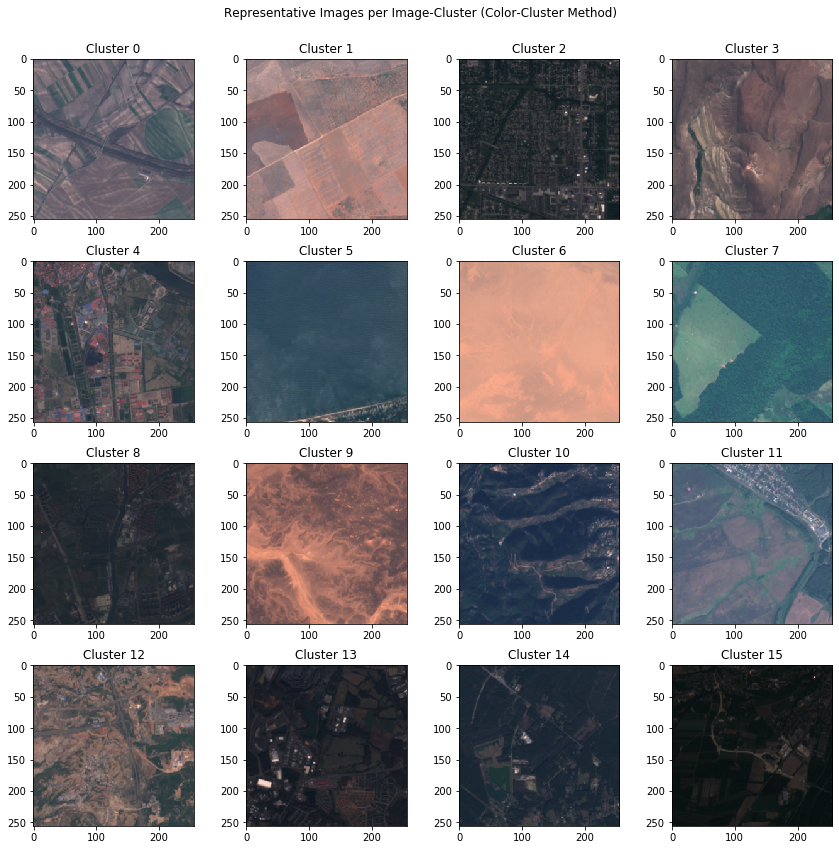

In [72]:
# Plot representative images (RGB)
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
row, col = 0, 0
for i, image_ind in enumerate(representative_image_inds):
    s2 = np.load(f'{patch_paths[image_ind]}/s2.npy')
    rgb = s2[:, :, [2, 1, 0]]
    rgb = rgb / rgb.max()
    axes[row, col].imshow(rgb)
    axes[row, col].set_title(f'Cluster {i}')
    col += 1
    if col == 4:
        row += 1
        col = 0
plt.suptitle('Representative Images per Image-Cluster (Color-Cluster Method)')
fig.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


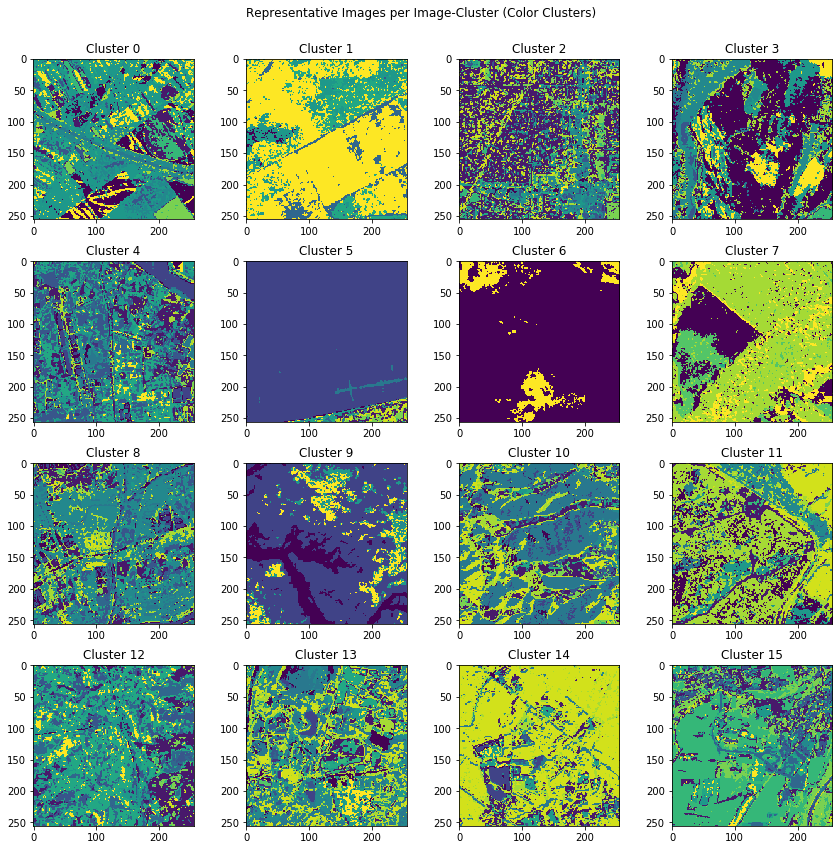

In [46]:
### Plot representative images (Color-Clusters) ###

# Set colormap
cmap = plt.cm.viridis  # define the colormap
cmaplist = [cmap(i) for i in np.linspace(0, 1, num_color_clusters)]
cmap = mpl.colors.ListedColormap(cmaplist)

# Create plot
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
row, col = 0, 0
for i, image_ind in enumerate(representative_image_inds):
    color_clusters = cluster_inds[image_ind].reshape((img_size, img_size))
    axes[row, col].imshow(color_clusters, cmap=cmap)
    axes[row, col].set_title(f'Cluster {i}')
    col += 1
    if col == 4:
        row += 1
        col = 0
plt.suptitle('Representative Images per Image-Cluster (Color Clusters)')
fig.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


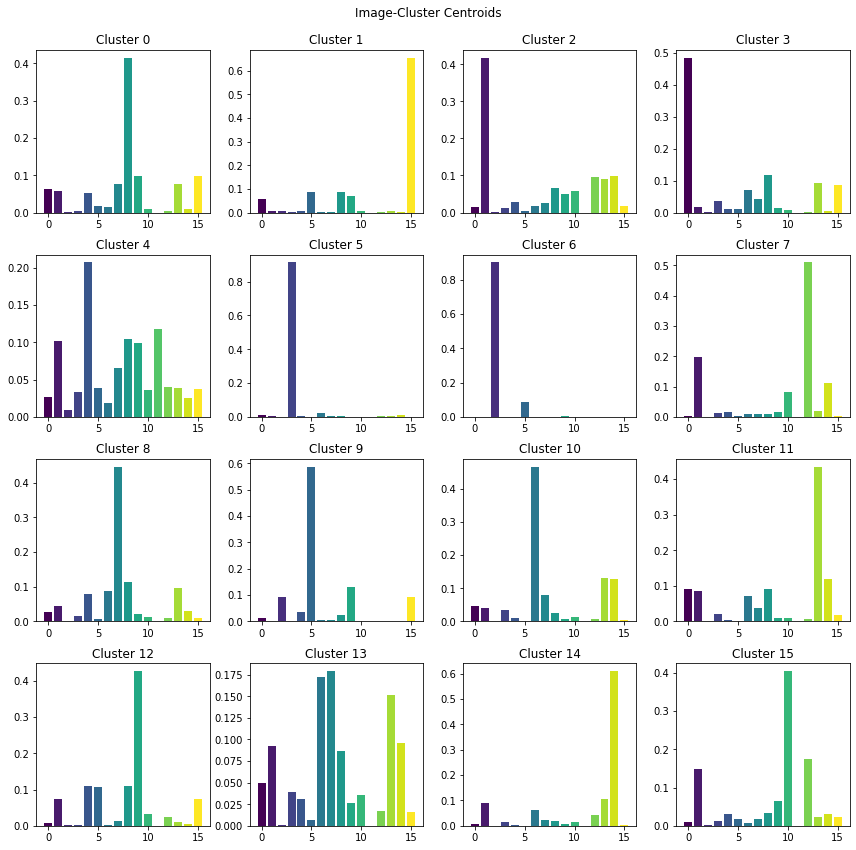

In [47]:
### Plot Image-Cluster centroids ###
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
row, col = 0, 0
cmap = plt.cm.viridis  # define the colormap
cmaplist = [cmap(i) for i in np.linspace(0, 1, num_color_clusters)]
for i, centroid in enumerate(kmeans_image.cluster_centers_):
    axes[row, col].bar(x=range(len(centroid)), height=centroid, color=cmaplist)
    axes[row, col].set_title(f'Cluster {i}')
    col += 1
    if col == 4:
        row += 1
        col = 0
plt.suptitle('Image-Cluster Centroids', fontsize='large')
fig.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

## Step 3: Fit Image-KMeans Model on Stacked Band Histograms

In [29]:
### Cluster images according to stacked band-histograms histogram ###

# Settings
num_image_clusters = 16
images_per_batch = 256
np.random.seed(20200407)

# update config
config['fc_densenet_params']['batch_size'] = images_per_batch # set batch size for datagen
config['training_params']['normalize_mode'] = None # disable band normalization

# Get all patch_paths
patch_paths = get_all_patch_paths()
print(f'Total number of patches: {len(patch_paths)}')

# Get datagen in random order
np.random.shuffle(patch_paths)
kmeans_datagen = datagen.SegmentationDataGenerator(patch_paths, config, labels=None)
pixels_per_batch = images_per_batch * img_size * img_size
print(f'Images per batch: {images_per_batch}')
print(f'Number of batches: {len(kmeans_datagen)}')
print(f'Pixels per batch: {pixels_per_batch}')
print()

# init image-kmeans model
kmeans_image = MiniBatchKMeans(num_image_clusters, batch_size=images_per_batch)

# get histogram boundaries
sen12_bins = get_sen12_bins()
print('SEN12 histogram boundaries:')
print(sen12_bins)
print()

# fit image-kmeans model on stacked S1/S2 band histograms
start = time.time()
print(f'--- Fitting Image-KMeans (Band Histograms) model with {num_image_clusters} clusters ---')
for i, batch in enumerate(kmeans_datagen):
    break # TODO: comment this line to train model
    if i % 20 == 0 and i != 0:
        seconds_per_batch = (time.time() - start) / i
        print(f'batch {i} out of {len(kmeans_datagen)} (seconds per batch: {seconds_per_batch:.2f})...')
    # get stacked band histograms for each image in batch
    stacked_band_hists = batch_to_stacked_band_histograms(batch, sen12_bins)
    if i == 0:
        print(f'color_ind_hists.shape: {stacked_band_hists.shape}')
    try:
        kmeans_image.partial_fit(stacked_band_hists)
    except:
        print('Warning: kmeans_image.partial_fit() on batch failed!')
        continue
    
# dump trained model
# save_dir = f'../kmeans/kmeans_image_bandhist_{num_image_clusters}.joblib'
# joblib.dump(kmeans_image, save_dir)
# print(f'Saved final KMeans model to {save_dir}!')
# print()


Total number of patches: 180662
Images per batch: 256
Number of batches: 706
Pixels per batch: 16777216

SEN12 histogram boundaries:
[[-5.000e+01 -1.421e+01 -1.199e+01 -8.840e+00  3.000e+04]
 [-5.000e+01 -2.153e+01 -1.883e+01 -1.508e+01  3.000e+04]
 [-5.000e+01  9.410e+02  1.099e+03  1.327e+03  3.000e+04]
 [-5.000e+01  8.000e+02  9.820e+02  1.250e+03  3.000e+04]
 [-5.000e+01  5.810e+02  8.860e+02  1.374e+03  3.000e+04]
 [-5.000e+01  8.690e+02  1.159e+03  1.548e+03  3.000e+04]
 [-5.000e+01  1.443e+03  1.882e+03  2.323e+03  3.000e+04]
 [-5.000e+01  1.631e+03  2.150e+03  2.732e+03  3.000e+04]
 [-5.000e+01  1.601e+03  2.110e+03  2.661e+03  3.000e+04]
 [-5.000e+01  1.805e+03  2.376e+03  3.013e+03  3.000e+04]
 [-5.000e+01  1.335e+03  1.882e+03  2.578e+03  3.000e+04]
 [-5.000e+01  6.570e+02  1.133e+03  1.823e+03  3.000e+04]]

--- Fitting Image-KMeans (Band Histograms) model with 16 clusters ---


Total number of patches: 180662
Generating subsample of dataset...
batch 0 out of 57...
batch 10 out of 57...
batch 20 out of 57...
batch 30 out of 57...
batch 40 out of 57...
batch 50 out of 57...
X.shape: (3648, 256, 256, 12)

Calculating SEN12 band histograms for each image...
band_hists.shape: (3648, 48)

Image-KMeans silhouette score: 0.2663887883637528

Cluster 0: /data/datasets/sen12ms_segmentation/North_America-summer/scene_26/patch_35
Cluster 1: /data/datasets/sen12ms_segmentation/Asia-winter/scene_108/patch_361
Cluster 2: /data/datasets/sen12ms_segmentation/Europe-spring/scene_126/patch_386
Cluster 3: /data/datasets/sen12ms_segmentation/Africa-winter/scene_8/patch_658
Cluster 4: /data/datasets/sen12ms_segmentation/Europe-spring/scene_120/patch_263
Cluster 5: /data/datasets/sen12ms_segmentation/Africa-winter/scene_47/patch_105
Cluster 6: /data/datasets/sen12ms_segmentation/Africa-winter/scene_29/patch_74
Cluster 7: /data/datasets/sen12ms_segmentation/Asia-fall/scene_61/patch_4

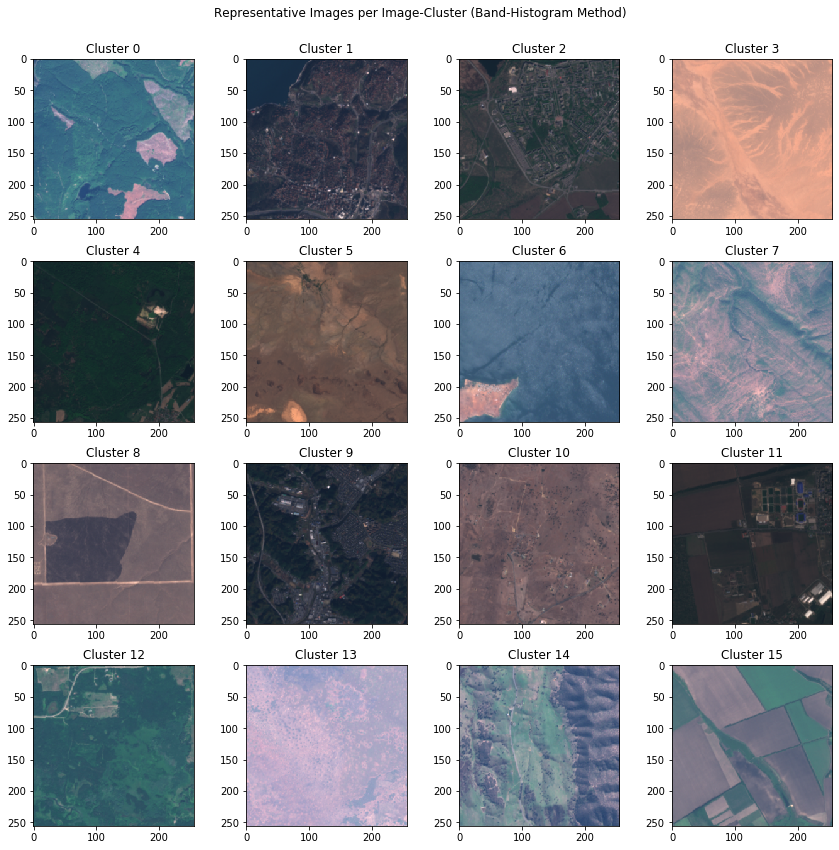

In [48]:
### Visualize "representative" images for each band-histogram image-cluster ###

# Settings
num_image_clusters = 16
images_per_batch = 64
patch_subsampling_factor = 50

np.random.seed(20200412)

# update config
config['fc_densenet_params']['batch_size'] = images_per_batch # set batch size for datagen
config['training_params']['normalize_mode'] = None # disable normalization

# Get all patch_paths
patch_paths = get_all_patch_paths()
print(f'Total number of patches: {len(patch_paths)}')

# Sample N images (patches)
print('Generating subsample of dataset...')
X = []
patch_paths = np.random.choice(patch_paths, len(patch_paths) // patch_subsampling_factor, replace=False)
np.random.shuffle(patch_paths)
kmeans_datagen = datagen.SegmentationDataGenerator(patch_paths, config, labels=None)
for i, batch in enumerate(kmeans_datagen):
    if i % 10 == 0:
        print(f'batch {i} out of {len(kmeans_datagen)}...')
    X.append(batch)
X = np.concatenate(X, axis=0)
print(f'X.shape: {X.shape}')
print()

# Get color-cluster histograms for each image
print('Calculating SEN12 band histograms for each image...')
sen12_bins = get_sen12_bins()
band_hists = np.vstack([image_to_stacked_band_histogram(image, sen12_bins) for image in X])
print(f'band_hists.shape: {band_hists.shape}')
print()

# Load image-kmeans model
kmeans_image = joblib.load(f'../kmeans/kmeans_image_bandhist_{num_image_clusters}.joblib')

# Get silhouette score
cluster_labels = kmeans_image.predict(band_hists)
score = silhouette_score(band_hists, cluster_labels)
print(f'Image-KMeans silhouette score: {score}')
print()
    
# Find images that are closest to each "image cluster" centroid
representative_image_inds = []
for i, centroid in enumerate(kmeans_image.cluster_centers_):
    nn_ind = nearest_neighbor_ind(band_hists, centroid)
    representative_image_inds.append(nn_ind)
    print(f'Cluster {i}: {patch_paths[nn_ind]}')

# Plot representative images (RGB)
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
row, col = 0, 0
for i, image_ind in enumerate(representative_image_inds):
    s2 = np.load(f'{patch_paths[image_ind]}/s2.npy')
    rgb = s2[:, :, [2, 1, 0]]
    rgb = rgb / rgb.max()
    axes[row, col].imshow(rgb)
    axes[row, col].set_title(f'Cluster {i}')
    col += 1
    if col == 4:
        row += 1
        col = 0
plt.suptitle('Representative Images per Image-Cluster (Band-Histogram Method)')
fig.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()
    

## Step 4: Fit Image-KMeans Model on Band Means

In [ ]:
### Cluster images according to band means ###

# Settings
num_image_clusters_list = [12, 10, 14]
images_per_batch = 256
np.random.seed(20200407)

# update config
config['fc_densenet_params']['batch_size'] = images_per_batch # set batch size for datagen
config['training_params']['normalize_mode'] = 'standardize'

# Get all patch_paths
patch_paths = get_all_patch_paths()
print(f'Total number of patches: {len(patch_paths)}')

# Get datagen in random order
np.random.shuffle(patch_paths)
kmeans_datagen = datagen.SegmentationDataGenerator(patch_paths, config, labels=None)
pixels_per_batch = images_per_batch * img_size * img_size
print(f'Images per batch: {images_per_batch}')
print(f'Number of batches: {len(kmeans_datagen)}')
print(f'Pixels per batch: {pixels_per_batch}')
print()

for num_image_clusters in num_image_clusters_list:
    
    break # TODO: comment this to train models

    # init image-kmeans model
    kmeans_image = MiniBatchKMeans(num_image_clusters, batch_size=images_per_batch)

    # fit image-kmeans model on vector of band means
    start = time.time()
    print(f'--- Fitting Image-KMeans (Band Means) model with {num_image_clusters} clusters ---')
    for i, batch in enumerate(kmeans_datagen):
    #     break # TODO: comment this line to train model
        if i % 20 == 0 and i != 0:
            seconds_per_batch = (time.time() - start) / i
            print(f'batch {i} out of {len(kmeans_datagen)} (seconds per batch: {seconds_per_batch:.2f})...')
        # get stacked band means for each image in batch
        band_means = batch_to_band_means(batch)
        if i == 0:
            print(f'band_means.shape: {band_means.shape}')
            print(f'band_means[0]: {band_means[0]}')
        try:
            kmeans_image.partial_fit(band_means)
        except:
            print('Warning: kmeans_image.partial_fit() on batch failed!')
            continue
    
    # reset datagen
    kmeans_datagen.on_epoch_end()

    # dump trained model
#     save_dir = f'../kmeans/kmeans_image_bandmeans_{num_image_clusters}.joblib'
#     joblib.dump(kmeans_image, save_dir)
#     print(f'Saved final KMeans model to {save_dir}!')
#     print()



## Step 5: Store Cluster Predictions in DF

In [ ]:
### Generate cluster-index predictions for every image ###

# Settings
num_color_clusters = 16
num_image_clusters = 16
images_per_batch = 64

csv_save_dir = '../kmeans/image_clusters_20200416.csv'
df_save_dir = '/data/lucas/kmeans/image_clusters_20200416_df.joblib'

np.random.seed(20200412)

# update config
config['fc_densenet_params']['batch_size'] = images_per_batch # set batch size for datagen
config['training_params']['normalize_mode'] = None

# get all continent-seasons
continent_seasons = get_all_continent_seasons()
        
# load kmeans models
kmeans_pixel_color = joblib.load(f'../kmeans/kmeans_{num_color_clusters}.joblib')
kmeans_image_color = joblib.load(f'../kmeans/kmeans_image_colorcluster_{num_image_clusters}.joblib')
kmeans_image_bandhist = joblib.load(f'../kmeans/kmeans_image_bandhist_{num_image_clusters}.joblib')
kmeans_image_bandmeans = joblib.load(f'../kmeans/kmeans_image_bandmeans_{num_image_clusters}.joblib')

# get sen12 histogram bins, standardized
sen12_bins = get_sen12_bins(standardize=False)

# setup CSV writer
fieldnames = ['continent', 'season', 'scene_id', 'patch_id',
              'image_cluster_color', 'image_cluster_bandhist', 'image_cluster_bandmeans']
writer = csv.DictWriter(open(csv_save_dir, 'w'), fieldnames)
writer.writeheader()

# keep list of tuples: 
# (c, s, scene, patch, color_cluster_hist, sen12_band_hist, sen12_band_means, image_cluster_color, image_cluster_bandhist, image_cluster_bandmeans)
record_tups = []
        
# evaluate images by continent-season
for continent, season in continent_seasons:
    print(f'----- Getting Image-Clusters for {continent}, {season} -----')
    # get datagen
    scene_dirs = land_cover_utils.get_scene_dirs_for_continent_season(continent, season, config)
    patch_paths = land_cover_utils.get_segmentation_patch_paths_for_scene_dirs(scene_dirs)
    kmeans_datagen = datagen.SegmentationDataGenerator(patch_paths, config, labels=None)
    # predict image-cluster batch-by-batch
    start = time.time()
    patch_index = 0
    for i, batch in enumerate(kmeans_datagen):
        if i == 0:
            print(f'batch {i+1} out of {len(kmeans_datagen)}...')
        elif i % 10 == 0:
            seconds_per_batch = (time.time() - start) / i
            print(f'batch {i+1} out of {len(kmeans_datagen)} (seconds per batch: {seconds_per_batch:.2f})...')
        batch_normalized = normalize_bands(batch)
        # predict image-clusters for each image in batch; write to .csv
        for image, image_normalized in zip(batch, batch_normalized):
            patch_path = patch_paths[patch_index]
            c, s, scene, patch = land_cover_utils.patch_path_to_geo_info(patch_path)
            # predict cluster based on color cluster histogram
            try:
                color_cluster_hist = image_to_color_cluster_hist(image_normalized, kmeans_pixel_color) # use normalized image
                image_cluster_color = kmeans_image_color.predict([color_cluster_hist])[0]
            except:
                color_ind_hist = None
                image_cluster_color = -1 # prediction failed (probably due to NaN in S1 band)
            # predict cluster based on stacked SEN12 band histogram
            sen12_band_hist = image_to_stacked_band_histogram(image, sen12_bins) # use unnormalized image
            image_cluster_bandhist = kmeans_image_bandhist.predict([sen12_band_hist])[0]
            # predict cluster based on SEN12 band means
            sen12_band_means = image_to_band_means(image_normalized)
            image_cluster_bandmeans = kmeans_image_bandmeans.predict([sen12_band_means])[0]
            # write to .csv
            record_tups.append((c, s, scene, patch, color_cluster_hist, sen12_band_hist, sen12_band_means, image_cluster_color, image_cluster_bandhist, image_cluster_bandmeans))
            writer.writerow({
                'continent': c,
                'season': s,
                'scene_id': scene,
                'patch_id': patch,
                'image_cluster_color': image_cluster_color,
                'image_cluster_bandhist': image_cluster_bandhist,
                'image_cluster_bandmeans': image_cluster_bandmeans
            })
            # increment patch_index
            patch_index += 1
    print()

# Save records as Pandas DataFrame
df = pd.DataFrame.from_records(record_tups, 
                               columns=['continent', 'season', 'scene_id', 'patch_id', 
                                        'color_cluster_hist', 'sen12_band_hist', 'sen12_band_means',
                                        'image_cluster_color', 'image_cluster_bandhist', 'image_cluster_bandmeans'])
joblib.dump(df, df_save_dir)
    
print('Done!')



Fitting bandmeans cluster model with K = 6...
Saved KMeans model to ../kmeans/kmeans_image_batch_bandmeans_6.joblib!

Fitting bandmeans cluster model with K = 8...
Saved KMeans model to ../kmeans/kmeans_image_batch_bandmeans_8.joblib!

Fitting bandmeans cluster model with K = 10...
Saved KMeans model to ../kmeans/kmeans_image_batch_bandmeans_10.joblib!

Fitting bandmeans cluster model with K = 12...
Saved KMeans model to ../kmeans/kmeans_image_batch_bandmeans_12.joblib!

Fitting bandmeans cluster model with K = 14...
Saved KMeans model to ../kmeans/kmeans_image_batch_bandmeans_14.joblib!

Fitting bandmeans cluster model with K = 16...
Saved KMeans model to ../kmeans/kmeans_image_batch_bandmeans_16.joblib!

Evaluating K=6...
Computing silhouette score...
Silhouette score: 0.3467980439507
Evaluating K=8...
Computing silhouette score...
Silhouette score: 0.30558563936377814
Evaluating K=10...
Computing silhouette score...
Silhouette score: 0.2666067378898127
Evaluating K=12...
Computing s

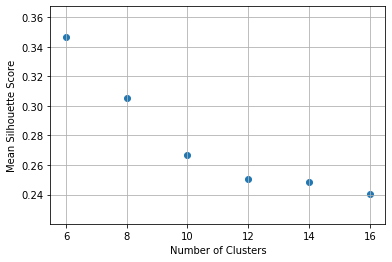

In [75]:
### Detour: Fit additional bandmeans kmeans models (non mini-batch) ###

np.random.seed(20200416)

df_save_dir = '/data/lucas/kmeans/image_clusters_df_20200416.joblib'
df = joblib.load(df_save_dir)
sen12_band_means = np.vstack(df['sen12_band_means'])
sen12_band_means_shuffled = np.random.permutation(sen12_band_means)

num_clusters_list = [6, 8, 10, 12, 14, 16]

# Fit kmeans models
for num_clusters in num_clusters_list:
#     break # TODO: comment to train
    # fit cluster model
    print(f'Fitting bandmeans cluster model with K = {num_clusters}...')
    kmeans_image = KMeans(num_clusters)
    kmeans_image.fit(sen12_band_means_shuffled)
    # save cluster model
    save_dir = f'../kmeans/kmeans_image_batch_bandmeans_{num_clusters}.joblib'
    joblib.dump(kmeans_image, save_dir)
    print(f'Saved KMeans model to {save_dir}!')
    print()
    
# Predict using kmeans models
for num_clusters in num_clusters_list:
    kmeans_image = joblib.load(f'../kmeans/kmeans_image_batch_bandmeans_{num_clusters}.joblib')
    df[f'image_cluster_bandmeans_{num_clusters}'] = kmeans_image.predict(sen12_band_means)
joblib.dump(df, df_save_dir)

# Compute silhouette scores on subset
silhouette_scores_list = []
subsample = np.random.choice(len(sen12_band_means), size=10000, replace=False)
sen12_band_means_subsample = sen12_band_means[subsample]
for num_clusters in num_clusters_list:
    # break # TODO: comment to evaluate
    print(f'Evaluating K={num_clusters}...')
    kmeans_image = joblib.load(f'../kmeans/kmeans_image_batch_bandmeans_{num_clusters}.joblib')
    # compute silhouette score
    cluster_labels = kmeans_image.predict(sen12_band_means_subsample)
    print('Computing silhouette score...')
    score = silhouette_score(sen12_band_means_subsample, cluster_labels)
    print(f'Silhouette score: {score}')
    silhouette_scores_list.append(score)
    
# # make scatter plot
plt.scatter(num_clusters_list, silhouette_scores_list)
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Silhouette Score')
plt.grid()
plt.show()
    

## Step 6: Compare Image-Clusters Between Continents

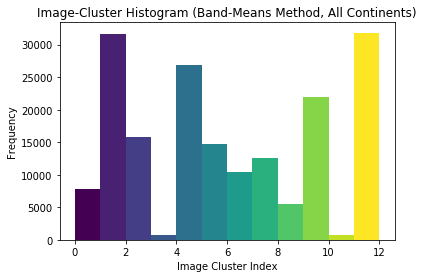

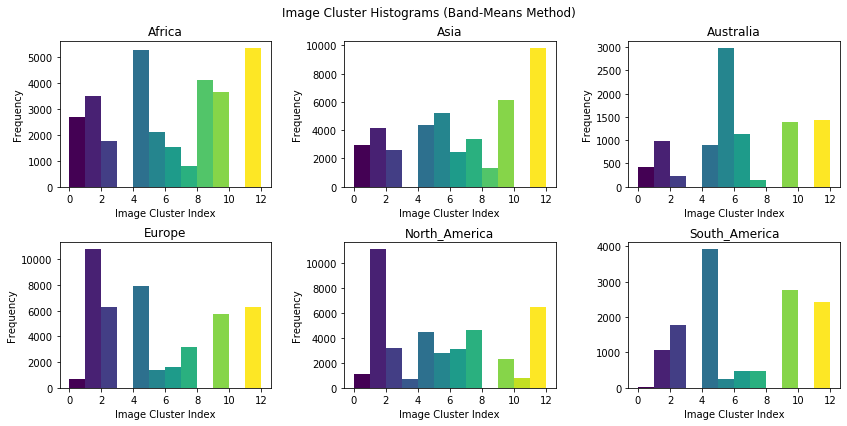

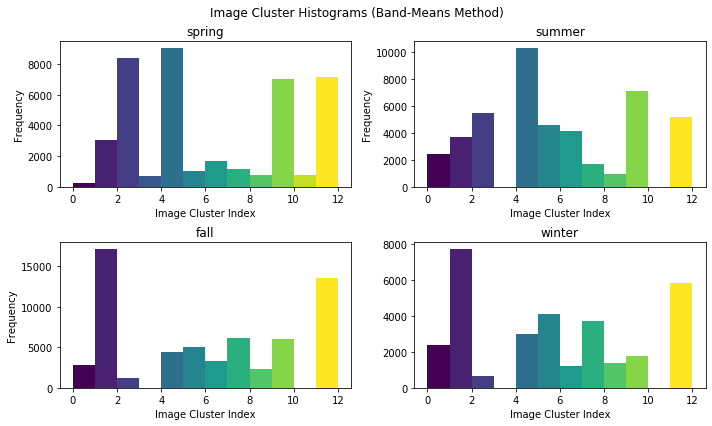

In [12]:
### Compare image-clusters between continents ###

num_clusters = 12

method = 'bandmeans' # one of 'colorcluster', 'bandhist', or 'bandmeans'
# cluster_col = cluster_method_to_cluster_col[method]
cluster_col = f'image_cluster_bandmeans_{num_clusters}'
feat_col = cluster_method_to_feat_col[method]
method_name = cluster_method_to_method_name[method]

# get image-cluster predictions
df_save_dir = '/data/lucas/kmeans/image_clusters_df_20200416.joblib'
df = joblib.load(df_save_dir)

# set colormap
cmap = plt.cm.viridis  # define the colormap
cmaplist = [cmap(i) for i in np.linspace(0, 1, num_clusters)]

# plot histogram for all continents
N, bins, patches = plt.hist(df[cluster_col], bins=range(0,num_clusters+1), density=False)
for i in range(len(patches)):
    patches[i].set_facecolor(cmaplist[i])
plt.title(f'Image-Cluster Histogram ({method_name} Method, All Continents)')
plt.xlabel('Image Cluster Index')
plt.ylabel('Frequency')

# Plot each individual continent
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
row, col = 0, 0
for i, continent in enumerate(config['all_continents']):
    if col > 2:
        row += 1
        col = 0
    N, bins, patches = axes[row, col].hist(df.loc[df['continent'] == continent][cluster_col], 
                                           bins=range(0,num_clusters+1), density=False)
    for i in range(len(patches)):
        patches[i].set_facecolor(cmaplist[i])
    axes[row, col].set_title(continent)
    axes[row, col].set_xlabel('Image Cluster Index')
    axes[row, col].set_ylabel('Frequency')
    col += 1
fig.tight_layout()
plt.suptitle(f'Image Cluster Histograms ({method_name} Method)')
fig.subplots_adjust(top=0.90)
plt.ylabel('')
plt.show()

# Plot each individual season
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
row, col = 0, 0
for i, season in enumerate(config['all_seasons']):
    if col >= 2:
        row += 1
        col = 0
    N, bins, patches = axes[row, col].hist(df.loc[df['season'] == season][cluster_col], 
                                           bins=range(0,num_clusters+1), density=False)
    for j in range(len(patches)):
        patches[j].set_facecolor(cmaplist[j])
    axes[row, col].set_title(season)
    axes[row, col].set_xlabel('Image Cluster Index')
    axes[row, col].set_ylabel('Frequency')
    col += 1
fig.tight_layout()
plt.suptitle(f'Image Cluster Histograms ({method_name} Method)')
fig.subplots_adjust(top=0.90)
plt.ylabel('')
plt.show()

Loading image cluster dataframe...
df.columns: Index(['continent', 'season', 'scene_id', 'patch_id', 'color_cluster_hist',
       'sen12_band_hist', 'sen12_band_means', 'image_cluster_color',
       'image_cluster_bandhist', 'image_cluster_bandmeans_6',
       'image_cluster_bandmeans_8', 'image_cluster_bandmeans_10',
       'image_cluster_bandmeans_12', 'image_cluster_bandmeans_14',
       'image_cluster_bandmeans_16'],
      dtype='object')

Loading image-kmeans model...
X.shape: (180662, 12)
kmeans_image.cluster_centers_.shape: (12, 12)

Image-cluster 0: /data/datasets/sen12ms_segmentation/Asia-fall/scene_84/patch_291
Image-cluster 1: /data/datasets/sen12ms_segmentation/Asia-fall/scene_116/patch_115
Image-cluster 2: /data/datasets/sen12ms_segmentation/South_America-fall/scene_132/patch_831
Image-cluster 3: /data/datasets/sen12ms_segmentation/North_America-spring/scene_26/patch_660
Image-cluster 4: /data/datasets/sen12ms_segmentation/Europe-spring/scene_112/patch_451
Image-cluster 5:

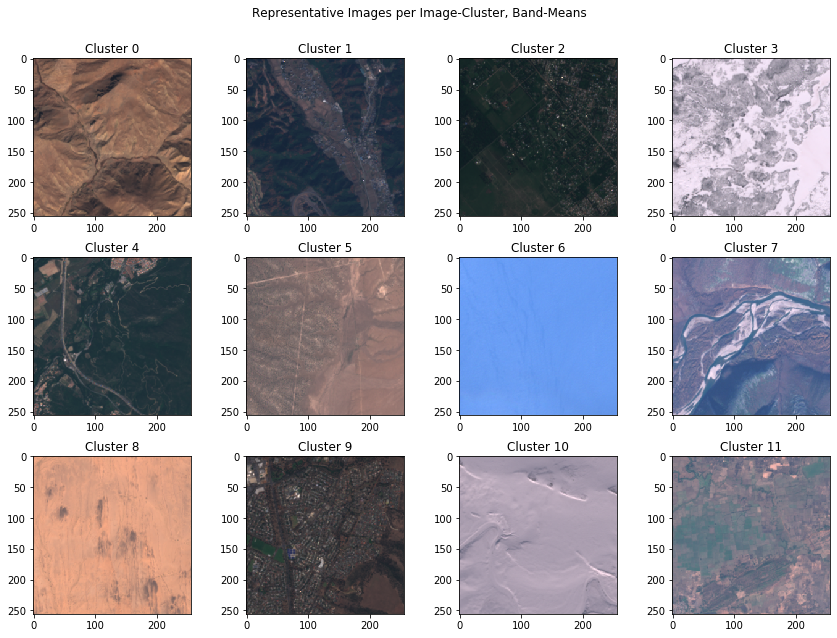

In [17]:
### Get representative images for each continent ###

# settings
df_save_dir = '/data/lucas/kmeans/image_clusters_df_20200416.joblib'
continent = None # pick a continent, or None for all continents

num_image_clusters = 12

method = 'bandmeans' # one of 'colorcluster', 'bandhist', or 'bandmeans'
# cluster_col = cluster_method_to_cluster_col[method]
cluster_col = f'image_cluster_bandmeans_{num_image_clusters}'
feat_col = cluster_method_to_feat_col[method]
method_name = cluster_method_to_method_name[method]

# load dataframe
print('Loading image cluster dataframe...')
df = joblib.load(df_save_dir)
continent_df = df.loc[df['continent'] == continent] if continent is not None else df
print(f'df.columns: {df.columns}')
print()

# load image-kmeans model
print('Loading image-kmeans model...')
kmeans_image = joblib.load(f'../kmeans/kmeans_image_batch_{method}_{num_image_clusters}.joblib')

# verify shapes
X = np.vstack(continent_df[feat_col])
print(f'X.shape: {X.shape}')
print(f'kmeans_image.cluster_centers_.shape: {kmeans_image.cluster_centers_.shape}')
print()

# Find images that are closest to each "image cluster" centroid
representative_patch_paths = []
for i, centroid in enumerate(kmeans_image.cluster_centers_):
    nn_ind = nearest_neighbor_ind(X, centroid)
    record = continent_df.iloc[nn_ind]
    patch_path = land_cover_utils.geo_info_to_patch_path(config['segmentation_dataset_dir'], 
                                                         record['continent'], record['season'], 
                                                         record['scene_id'], record['patch_id'])
    print(f'Image-cluster {i}: {patch_path}')
    representative_patch_paths.append(patch_path)
    
# Plot representative images (RGB)
rows = num_image_clusters // 4
fig, axes = plt.subplots(rows, 4, figsize=(12, rows*3))
row, col = 0, 0
for i, patch_path in enumerate(representative_patch_paths):
    s2 = np.load(f'{patch_path}/s2.npy')
    rgb = s2[:, :, [2, 1, 0]]
    rgb = rgb / rgb.max()
    axes[row, col].imshow(rgb)
    axes[row, col].set_title(f'Cluster {i}')
    col += 1
    if col == 4:
        row += 1
        col = 0
continent_str = f' ({continent})' if continent is not None else ''
plt.suptitle(f'Representative Images per Image-Cluster, {method_name}{continent_str}')
fig.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()
    

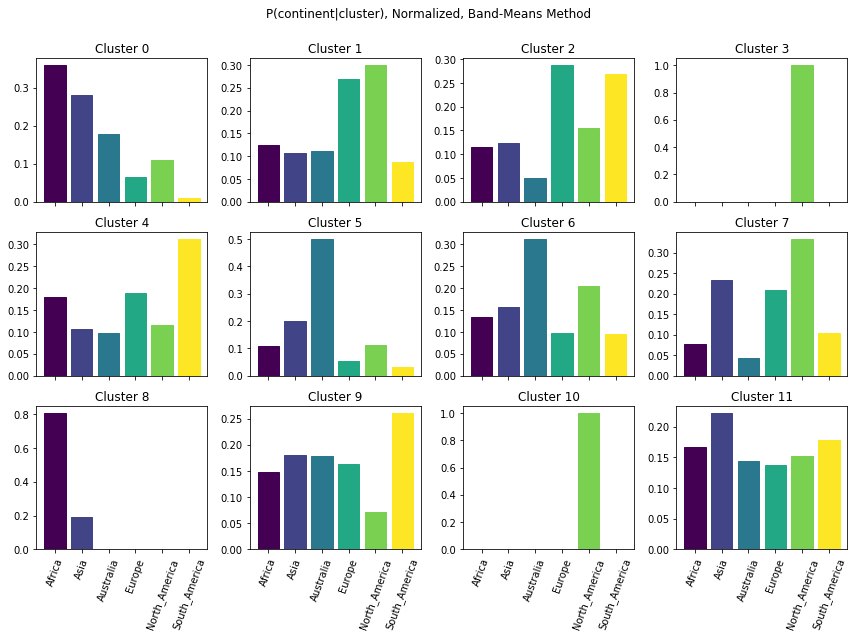

Mean entropy (unweighted): 1.270825630955018
Mean entropy (weighted): 1.6193383186209118
Median entropy: 1.629350267523341


In [16]:
### Get P(continent|cluster) ###

num_image_clusters = 12

method = 'bandmeans' # one of 'colorcluster', 'bandhist', or 'bandmeans'
# cluster_col = cluster_method_to_cluster_col[method]
cluster_col = f'image_cluster_bandmeans_{num_image_clusters}'
feat_col = cluster_method_to_feat_col[method]
method_name = cluster_method_to_method_name[method]

# set colormap
cmap = plt.cm.viridis  # define the colormap
cmaplist = [cmap(i) for i in np.linspace(0, 1, 6)]

rows = num_image_clusters // 4
fig, axes = plt.subplots(rows, 4, figsize=(12, rows * 3), sharex=True)
row = 0
col = 0
p_continent = df['continent'].value_counts(normalize=True)
p_cluster = df[cluster_col].value_counts(normalize=True).sort_index()
p_cluster = p_cluster.loc[p_cluster.index >= 0]
entropies = []
for cluster in range(0, num_image_clusters):
    in_cluster_continent_counts = df.loc[df[cluster_col] == cluster]['continent'].value_counts()
    p_continent_cluster_normalized = in_cluster_continent_counts / p_continent # upscale less frequent continents
    p_continent_cluster_normalized /= p_continent_cluster_normalized.sum() # sum to 1
    entropies.append(sp_stats.entropy(p_continent_cluster_normalized.loc[p_continent_cluster_normalized > 0]))
    axes[row, col].set_title(f'Cluster {cluster}')
    bars = axes[row, col].bar(p_continent_cluster_normalized.index, p_continent_cluster_normalized)
    for i in range(len(bars)):
        bars[i].set_color(cmaplist[i])
    axes[row, col].tick_params(axis='x', labelrotation=70)
    col += 1
    if col >= 4:
        col = 0
        row += 1
fig.tight_layout()
plt.suptitle(f'P(continent|cluster), Normalized, {method_name} Method')
fig.subplots_adjust(top=0.90)
plt.show()

# get avg. entropy across clusters
print(f'Mean entropy (unweighted): {np.average(entropies)}')
print(f'Mean entropy (weighted): {np.average(entropies, weights=p_cluster)}')
print(f'Median entropy: {np.median(entropies)}')